In [1]:
## Import necessary libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Get the required functions
from helper_functions import unzip_data, create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys

--2024-01-26 08:57:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-26 08:57:36 (74.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Download the text dataset

In [3]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2024-01-26 08:57:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-01-26 08:57:37 (149 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



# Visualize the text dataset

In [4]:
# Turn csv files into dataframes
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataset
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# checkout test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many example of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [9]:
# visualize random training examples
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target,  = row
  print(f"Target :{target}", "(real disaster)" if target >0 else" (not real disaster)")
  print(f"Text: \n {text}\n")
  print("----")


Target :1 (real disaster)
Text: 
 #hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/qj3PVgaVN7 #prebreak #best

----
Target :0  (not real disaster)
Text: 
 I liked a @YouTube video from @dannyonpc http://t.co/AD38KWoGlh Battlefield Hardline - 11 NEW WEAPONS - New map - Throwingknifes!

----
Target :0  (not real disaster)
Text: 
 Even when I was a kid haha super late but folks used to bash me for that shit I understand he survived cancer but he still cheated

----
Target :0  (not real disaster)
Text: 
 Do you feel engulfed with low self-image? Take the quiz: http://t.co/ykVsttvDWo http://t.co/IFQQpUr99X

----
Target :1 (real disaster)
Text: 
 I can probably skip on these basic life maintenance things for a few days. (cut to burning buildings people screaming in the streets)

----


# Split the data into train-test

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                         train_df_shuffled["target"].to_numpy(),
                                                                         test_size = 0.1,
                                                                         random_state = 42)

In [11]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Text to Numbers Conversion

## Text Vectorization (Tokenization)

In [13]:
from tensorflow.keras.layers import TextVectorization

In [14]:
# Initialize the text vectorizer
text_vectorizer = TextVectorization(max_tokens= None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None, # create group of words
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    #pad_to_max_tokens = True
                                    )

In [15]:
# Find average number of tokens (word) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [16]:
# Set up text vectorization variables
max_vocab_length = 10000 # max number of words in vocab
max_length = 15 # how many words from tweet we will reading

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length
                                    )

In [17]:
# Fit the text vectorizer to training set
text_vectorizer.adapt(data = train_sentences, )

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose random sentence from training data
random_sentence = random.choice(train_sentences)
print(f"Original Text : \n {random_sentence}\
       \n\nVectorized version :\n\
       {text_vectorizer(random_sentence)}")

Original Text : 
 @BrandonMulcahy @fpine Here's the story http://t.co/TgXutUoyHl       

Vectorized version :
       [   1    1 1664    2  451    1    0    0    0    0    0    0    0    0
    0]


In [20]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Creating an Embedding using Embedding Layer


In [21]:
from tensorflow.keras.layers import Embedding

In [22]:
embedding = Embedding(input_dim = max_vocab_length,
                      input_length = max_length,
                      output_dim = 128
                      )

embedding

In [23]:
# Get another random sentence
random_sentence = random.choice(train_sentences)
print(f"Original Sentence :\n{random_sentence},\
      \n\nEmbedded Sentence :\n")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence :
Dudes will thoroughly express how stupid black ppl r for burning buildings in response to brutality but nvr mention them being mistreated.,      

Embedded Sentence :



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03428656, -0.00031754,  0.00662688, ..., -0.0418694 ,
          0.002723  , -0.0144705 ],
        [-0.03647497, -0.00856624, -0.02693873, ..., -0.01198737,
         -0.01651742, -0.03273895],
        [-0.03767493,  0.03592231, -0.00990195, ..., -0.03991598,
         -0.00468845, -0.02755007],
        ...,
        [ 0.01767695, -0.0250605 ,  0.00847935, ...,  0.03434023,
         -0.03081609,  0.03707509],
        [ 0.03613624,  0.01937434,  0.04876206, ...,  0.04166049,
          0.04654497,  0.04750473],
        [-0.01284496, -0.00204074,  0.03147265, ...,  0.01335612,
          0.03482366,  0.02825658]]], dtype=float32)>

In [24]:
# Check out sigle tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03428656, -0.00031754,  0.00662688, -0.01467158, -0.0331512 ,
        -0.01528019, -0.04971485, -0.04608672,  0.02938285, -0.03840091,
        -0.02174031,  0.04757578, -0.04381241,  0.04190985, -0.00411637,
         0.03236042,  0.04440776,  0.04341185,  0.0119997 , -0.03923284,
        -0.02003119, -0.04643114, -0.00693507, -0.01801416,  0.0350737 ,
        -0.03246304, -0.02740678,  0.00780278, -0.00184481, -0.02310041,
         0.00445777, -0.01614703,  0.03361524, -0.0036283 , -0.0257757 ,
        -0.0317434 ,  0.00227113, -0.03059781, -0.03078585,  0.03254915,
        -0.02981962,  0.00367745, -0.04164005,  0.02531103, -0.03816324,
        -0.01363676,  0.01752481,  0.00804471, -0.03551579,  0.02238165,
         0.03759095,  0.04944072, -0.04856628, -0.01043247,  0.03817168,
        -0.0386359 ,  0.00946616, -0.00773939,  0.01807201, -0.0362584 ,
        -0.04117697,  0.04486165,  0.03730157, -0.0062486 , -0.03797823,
  

# Modelling on Text Dataset

## Model 0

In [25]:
## Model 0 : Getting a baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [26]:
# Create  tokenization and modelling pipeline
model0 = Pipeline([
      ("tfidf", TfidfVectorizer()), # Convert words to number using tf-idf
      ("clf", MultinomialNB())
])

# Fit the pipeline to training data
model0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate the model
baseline_score = model0.score(val_sentences, val_labels)
print(f"Baseline model achieves accuracy of : {baseline_score * 100:.2f}%")

Baseline model achieves accuracy of : 79.27%


In [28]:
val_labels[:20]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [29]:
# Make predictions
baseline_preds = model0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (new callback for each new model)
from helper_functions import create_tensorboard_callback

# create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with Functional API
inputs = layers.Input(shape = (1,), dtype = tf.string) # inputs are 1D strings
x = text_vectorizer(inputs) # Turn the input text to number
x = embedding(x) # Turn the numbers to embeddings
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = keras.Model(inputs, outputs, name ="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

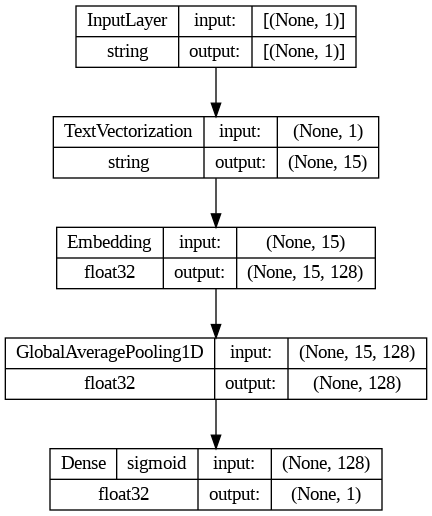

In [35]:
# plot the model
from tensorflow.keras.utils import plot_model

# Pass the model to function for plotting
plot_model(model_1, show_shapes=True, show_dtype=True, show_layer_names=False, show_layer_activations=True)

In [36]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=20,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240126-085741
Epoch 1/20
215/215 [==============================] - 9s 30ms/step - loss: 0.6123 - accuracy: 0.6897 - val_loss: 0.5363 - val_accuracy: 0.7651
Epoch 2/20
215/215 [==============================] - 2s 10ms/step - loss: 0.4408 - accuracy: 0.8181 - val_loss: 0.4697 - val_accuracy: 0.7848
Epoch 3/20
215/215 [==============================] - 2s 10ms/step - loss: 0.3462 - accuracy: 0.8610 - val_loss: 0.4568 - val_accuracy: 0.7900
Epoch 4/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2839 - accuracy: 0.8908 - val_loss: 0.4671 - val_accuracy: 0.7940
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2369 - accuracy: 0.9105 - val_loss: 0.4811 - val_accuracy: 0.7769
Epoch 6/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2006 - accuracy: 0.9280 - val_loss: 0.5020 - val_accuracy: 0.7782
Epoch 7/20
215/215 [==============================] - 1s 5ms/step 

In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.9261 - accuracy: 0.7638


[0.9261173605918884, 0.7637795209884644]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [39]:
# Convert model prediction probs to label format
model_1_pred = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [40]:
# Calculate model 1 results
model_1_results = calculate_results(val_labels, model_1_pred)
model_1_results

{'accuracy': 76.37795275590551,
 'precision': 0.7642156268927923,
 'recall': 0.7637795275590551,
 'f1': 0.7622584108804583}

In [41]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%tensorboard --logdir model_logs
#!kill 85358

In [42]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Visualize the embeddings

In [43]:
# Check the embedding weights
embedding.weights

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.00972252, -0.04707991, -0.00342408, ...,  0.00722545,
          0.02236881, -0.06056102],
        [-0.02541916, -0.01587931,  0.02765274, ..., -0.00836424,
          0.01550864, -0.02716446],
        [ 0.06531516, -0.01738051,  0.01048119, ...,  0.01483311,
          0.04358215,  0.00994085],
        ...,
        [-0.02729386,  0.00094838,  0.00384156, ..., -0.01943443,
          0.02829674,  0.0390121 ],
        [ 0.08423451, -0.0086446 , -0.0600832 , ..., -0.07161437,
          0.07356992, -0.07069411],
        [ 0.18294087, -0.22023228, -0.20068365, ..., -0.22025187,
          0.1654939 , -0.17716502]], dtype=float32)>]

In [44]:
len(words_in_vocab ), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights

array([[-0.00972252, -0.04707991, -0.00342408, ...,  0.00722545,
         0.02236881, -0.06056102],
       [-0.02541916, -0.01587931,  0.02765274, ..., -0.00836424,
         0.01550864, -0.02716446],
       [ 0.06531516, -0.01738051,  0.01048119, ...,  0.01483311,
         0.04358215,  0.00994085],
       ...,
       [-0.02729386,  0.00094838,  0.00384156, ..., -0.01943443,
         0.02829674,  0.0390121 ],
       [ 0.08423451, -0.0086446 , -0.0600832 , ..., -0.07161437,
         0.07356992, -0.07069411],
       [ 0.18294087, -0.22023228, -0.20068365, ..., -0.22025187,
         0.1654939 , -0.17716502]], dtype=float32)

In [46]:
embed_weights.shape

(10000, 128)

In [47]:
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:s
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

# Recurrent Neural Networks (RNN's)



## Model 2: LSTM (Long Short Term Memory)

In [48]:
# Create an LSTM Model
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences = True)(x)
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Make the model
model_2 = keras.Model(inputs, outputs, name = "model_2_LSTM")


In [49]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [50]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])



In [51]:
# Fit the model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs = 20,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [create_tensorboard_callback(SAVE_DIR, "model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20240126-085815
Epoch 1/20
215/215 [==============================] - 12s 39ms/step - loss: 0.1130 - accuracy: 0.9664 - val_loss: 0.8269 - val_accuracy: 0.7651
Epoch 2/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0559 - accuracy: 0.9791 - val_loss: 1.0841 - val_accuracy: 0.7651
Epoch 3/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0523 - accuracy: 0.9785 - val_loss: 1.2121 - val_accuracy: 0.7559
Epoch 4/20
215/215 [==============================] - 2s 8ms/step - loss: 0.0507 - accuracy: 0.9787 - val_loss: 0.8040 - val_accuracy: 0.7598
Epoch 5/20
215/215 [==============================] - 2s 7ms/step - loss: 0.0440 - accuracy: 0.9820 - val_loss: 1.6599 - val_accuracy: 0.7572
Epoch 6/20
215/215 [==============================] - 1s 7ms/step - loss: 0.0416 - accuracy: 0.9803 - val_loss: 1.1758 - val_accuracy: 0.7625
Epoch 7/20
215/215 [==============================] - 2s 7ms/step - loss

In [52]:
# Make predictions with lstm
model_2_prob_preds = model_2.predict(val_sentences)
model_2_prob_preds[:10]

24/24 [==============================] - 0s 3ms/step


array([[9.9928313e-01],
       [8.0069947e-01],
       [9.9999130e-01],
       [4.6104994e-01],
       [8.3200871e-07],
       [9.9999702e-01],
       [9.9040002e-01],
       [1.0000000e+00],
       [9.9999988e-01],
       [9.9999928e-01]], dtype=float32)

In [53]:
# convert the preds to labels
model_2_preds = tf.squeeze(tf.round(model_2_prob_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 74.40944881889764,
 'precision': 0.7451378315830596,
 'recall': 0.7440944881889764,
 'f1': 0.7443996252915018}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 3 : GRU

In [56]:
# Create a GRU network
inputs = layers.Input(shape = (1,), dtype ="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="GRU_output")(x)

# model
model_3 = keras.Model(inputs, outputs)

In [57]:
# Model summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                             

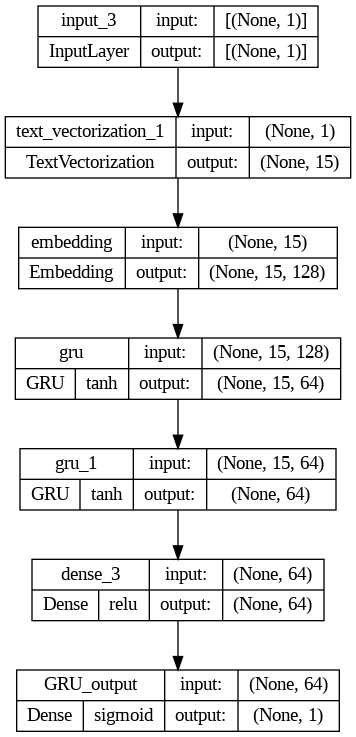

In [58]:
plot_model(model_3, show_shapes=True, show_layer_activations=True)

In [59]:
# Copmpile model
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )

# Fit the model
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        validation_data = (val_sentences, val_labels),
                        epochs =50,
                        callbacks = [create_tensorboard_callback(SAVE_DIR, "gru")]
                        )

Saving TensorBoard log files to: model_logs/gru/20240126-085940
Epoch 1/50
215/215 [==============================] - 12s 39ms/step - loss: 0.1075 - accuracy: 0.9606 - val_loss: 0.9277 - val_accuracy: 0.7507
Epoch 2/50
215/215 [==============================] - 3s 13ms/step - loss: 0.0458 - accuracy: 0.9818 - val_loss: 1.2174 - val_accuracy: 0.7585
Epoch 3/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0385 - accuracy: 0.9816 - val_loss: 1.8194 - val_accuracy: 0.7520
Epoch 4/50
215/215 [==============================] - 2s 10ms/step - loss: 0.0341 - accuracy: 0.9841 - val_loss: 2.0409 - val_accuracy: 0.7454
Epoch 5/50
215/215 [==============================] - 2s 10ms/step - loss: 0.0333 - accuracy: 0.9823 - val_loss: 1.8801 - val_accuracy: 0.7546
Epoch 6/50
215/215 [==============================] - 2s 11ms/step - loss: 0.0324 - accuracy: 0.9838 - val_loss: 2.0051 - val_accuracy: 0.7520
Epoch 7/50
215/215 [==============================] - 2s 9ms/step - loss: 0.03

In [60]:
# Evaluate model
model_3.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 2.1023 - accuracy: 0.7585


[2.1023192405700684, 0.7585301995277405]

In [61]:
# Model 3 predictions probs
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[6.1716484e-05],
       [9.9567246e-01],
       [9.9999785e-01],
       [3.4972334e-01],
       [2.5533740e-05],
       [9.9999845e-01],
       [9.9999130e-01],
       [9.9999928e-01],
       [9.9999905e-01],
       [9.9999821e-01]], dtype=float32)

In [62]:
# convert the preds to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 75.8530183727034,
 'precision': 0.7596068059293093,
 'recall': 0.7585301837270341,
 'f1': 0.7564745575824241}

## Model 4 : Bidirectional RNN

In [64]:
# Create model
input = layers.Input(shape = (1,), dtype="string")
x = text_vectorizer(input)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(64, activation= "relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Model
model_4 = keras.Model(input, output)

In [65]:
# Summary
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                           

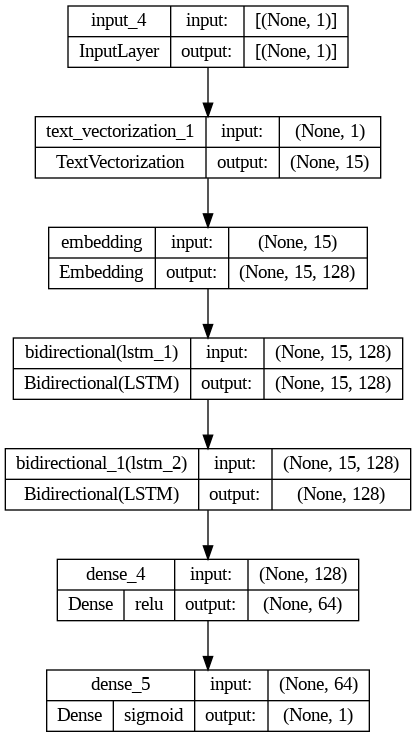

In [66]:
plot_model(model_4, show_layer_activations=True, show_shapes=True)

In [67]:
# Compile model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_4 = model_4.fit(train_sentences,
              train_labels,
              epochs=20,
              validation_data= (val_sentences, val_labels),
              callbacks = [create_tensorboard_callback(SAVE_DIR, "bidirectional")]
              )

Saving TensorBoard log files to: model_logs/bidirectional/20240126-090207
Epoch 1/20
215/215 [==============================] - 16s 45ms/step - loss: 0.0739 - accuracy: 0.9778 - val_loss: 1.3140 - val_accuracy: 0.7546
Epoch 2/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0367 - accuracy: 0.9834 - val_loss: 1.3861 - val_accuracy: 0.7480
Epoch 3/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0322 - accuracy: 0.9844 - val_loss: 1.7957 - val_accuracy: 0.7533
Epoch 4/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0306 - accuracy: 0.9848 - val_loss: 1.6253 - val_accuracy: 0.7467
Epoch 5/20
215/215 [==============================] - 2s 11ms/step - loss: 0.0303 - accuracy: 0.9845 - val_loss: 2.0769 - val_accuracy: 0.7402
Epoch 6/20
215/215 [==============================] - 3s 12ms/step - loss: 0.0316 - accuracy: 0.9842 - val_loss: 1.7175 - val_accuracy: 0.7546
Epoch 7/20
215/215 [==============================] - 3s 13ms/step 

In [68]:
# Predict
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[2.5473416e-03],
       [8.9742756e-01],
       [9.9999678e-01],
       [7.5933957e-01],
       [3.0266024e-06],
       [9.9999237e-01],
       [9.9901402e-01],
       [9.9999976e-01],
       [9.9999785e-01],
       [9.9971145e-01]], dtype=float32)

In [69]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.40944881889764,
 'precision': 0.7441190004660975,
 'recall': 0.7440944881889764,
 'f1': 0.7425086575551497}

In [71]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


In [72]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 74.41, Difference: -4.86
Baseline precision: 0.81, New precision: 0.74, Difference: -0.07
Baseline recall: 0.79, New recall: 0.74, Difference: -0.05
Baseline f1: 0.79, New f1: 0.74, Difference: -0.04


# Convolution Neural Networks for Text

## Model 5: Conv1D

In [73]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [74]:
# Create the model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 32, kernel_size=5, activation="relu", padding="valid", strides=1)(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = keras.Model(inputs, outputs)

# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
                )

# summary
model_5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)                 33  

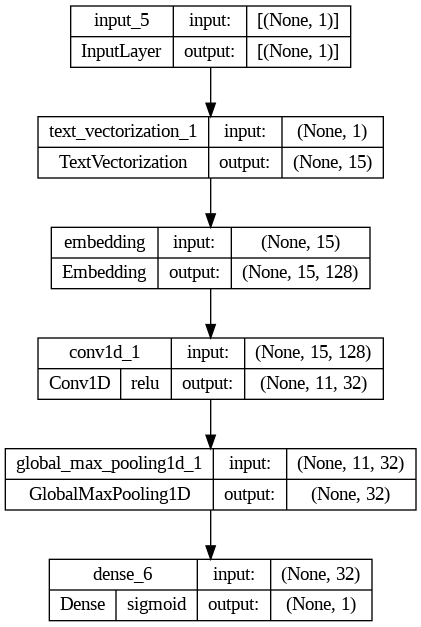

In [75]:
# Plot
plot_model(model_5, show_layer_activations=True, show_shapes =True)

In [76]:
# fit the model
model_5.fit(train_sentences,
            train_labels,
            epochs=20,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, "convo")]
            )

Saving TensorBoard log files to: model_logs/convo/20240126-090317
Epoch 1/20
215/215 [==============================] - 9s 35ms/step - loss: 0.1074 - accuracy: 0.9648 - val_loss: 1.0007 - val_accuracy: 0.7467
Epoch 2/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0614 - accuracy: 0.9769 - val_loss: 1.1342 - val_accuracy: 0.7480
Epoch 3/20
215/215 [==============================] - 1s 7ms/step - loss: 0.0494 - accuracy: 0.9822 - val_loss: 1.2753 - val_accuracy: 0.7559
Epoch 4/20
215/215 [==============================] - 1s 7ms/step - loss: 0.0432 - accuracy: 0.9829 - val_loss: 1.3699 - val_accuracy: 0.7559
Epoch 5/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0415 - accuracy: 0.9810 - val_loss: 1.4260 - val_accuracy: 0.7493
Epoch 6/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0405 - accuracy: 0.9822 - val_loss: 1.4063 - val_accuracy: 0.7402
Epoch 7/20
215/215 [==============================] - 1s 6ms/step - loss: 0.0387

In [77]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[5.6358033e-01],
       [9.6455616e-01],
       [9.9996674e-01],
       [5.4040277e-01],
       [6.8354910e-07],
       [9.9525648e-01],
       [9.6171665e-01],
       [9.9998236e-01],
       [9.9999857e-01],
       [9.8197973e-01]], dtype=float32)

In [78]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 73.22834645669292,
 'precision': 0.7317704975613227,
 'recall': 0.7322834645669292,
 'f1': 0.7311642748840393}

In [80]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 73.23, Difference: -6.04
Baseline precision: 0.81, New precision: 0.73, Difference: -0.08
Baseline recall: 0.79, New recall: 0.73, Difference: -0.06
Baseline f1: 0.79, New f1: 0.73, Difference: -0.06


# Using Pretrained Embeddings (transfer learning for NLP)

## Model 6 : using pretrained embeddings

In [81]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01602837  0.01068852  0.02425464 -0.01405769  0.01434426  0.08292626
  0.01963369  0.06160141 -0.00352701 -0.01216415  0.00978648 -0.01248499
  0.01232347  0.09748451  0.06141112 -0.03728352  0.01860888 -0.04669852
  0.00413912 -0.06363907 -0.02469896  0.02713691  0.02284444 -0.00210029
 -0.00630592 -0.0396496   0.02220408  0.00115074 -0.03132181  0.00119527
 -0.0401255   0.04561894 -0.01530597 -0.00175915  0.02173133 -0.08450424
  0.03340028  0.04604554 -0.02480249 -0.08681662  0.00702696 -0.00770476
 -0.01434537  0.07814164 -0.10676058 -0.05152996 -0.00858159 -0.0323223
 -0.03871096  0.02581471], shape=(50,), dtype=float32)


In [82]:
embed_samples.shape

TensorShape([2, 512])

In [83]:
# Create model

# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [84]:
# Create model using Sequential API

model_6 = Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="model_6_USE")
])

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 model_6_USE (Dense)         (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [85]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=20,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240126-090423
Epoch 1/20
215/215 [==============================] - 5s 13ms/step - loss: 0.5018 - accuracy: 0.7841 - val_loss: 0.4471 - val_accuracy: 0.8045
Epoch 2/20
215/215 [==============================] - 4s 17ms/step - loss: 0.4129 - accuracy: 0.8168 - val_loss: 0.4366 - val_accuracy: 0.8150
Epoch 3/20
215/215 [==============================] - 2s 11ms/step - loss: 0.4008 - accuracy: 0.8229 - val_loss: 0.4296 - val_accuracy: 0.8097
Epoch 4/20
215/215 [==============================] - 2s 11ms/step - loss: 0.3923 - accuracy: 0.8260 - val_loss: 0.4280 - val_accuracy: 0.8110
Epoch 5/20
215/215 [==============================] - 2s 11ms/step - loss: 0.3861 - accuracy: 0.8307 - val_loss: 0.4261 - val_accuracy: 0.8150
Epoch 6/20
215/215 [==============================] - 3s 12ms/step - loss: 0.3796 - accuracy: 0.8335 - val_loss: 0.4260 - val_accuracy: 0.8215
Epoch 7/20
215/215 [==============================] - 3s 1

In [86]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.11540896],
       [0.7881646 ],
       [0.9995096 ],
       [0.20831783],
       [0.6531681 ],
       [0.69494045],
       [0.99430734],
       [0.9972121 ],
       [0.97210723],
       [0.04418984]], dtype=float32)

In [87]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8223219905078891,
 'recall': 0.8202099737532809,
 'f1': 0.8188242643827762}

In [89]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 82.02, Difference: 2.76
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


## Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [90]:
# Create subset of 10% of training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [91]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            np.array(train_labels),
                                                                                                                            test_size=0.1,
                                                                                                                            random_state = 42)


In [92]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [93]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [94]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 model_6_USE (Dense)         (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [95]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=20,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240126-090553
Epoch 1/20
22/22 [==============================] - 3s 45ms/step - loss: 0.6711 - accuracy: 0.6327 - val_loss: 0.6520 - val_accuracy: 0.6693
Epoch 2/20
22/22 [==============================] - 1s 25ms/step - loss: 0.6027 - accuracy: 0.7843 - val_loss: 0.5990 - val_accuracy: 0.7415
Epoch 3/20
22/22 [==============================] - 1s 26ms/step - loss: 0.5298 - accuracy: 0.8178 - val_loss: 0.5467 - val_accuracy: 0.7651
Epoch 4/20
22/22 [==============================] - 0s 22ms/step - loss: 0.4663 - accuracy: 0.8338 - val_loss: 0.5063 - val_accuracy: 0.7782
Epoch 5/20
22/22 [==============================] - 1s 26ms/step - loss: 0.4201 - accuracy: 0.8309 - val_loss: 0.4915 - val_accuracy: 0.7808
Epoch 6/20
22/22 [==============================] - 1s 26ms/step - loss: 0.3875 - accuracy: 0.8382 - val_loss: 0.4812 - val_accuracy: 0.7874
Epoch 7/20
22/22 [==============================] - 1s 26ms

In [96]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.20660517],
       [0.9840894 ],
       [0.99376416],
       [0.12717445],
       [0.2775467 ],
       [0.961464  ],
       [0.97299296],
       [0.9140305 ],
       [0.94403636],
       [0.02546297]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7844894281510498,
 'recall': 0.7808398950131233,
 'f1': 0.77812284684276}

In [99]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 78.08, Difference: -1.18
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Comparing the performance of each of our models

In [100]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,76.377953,0.764216,0.763780,0.762258
lstm,74.409449,0.745138,0.744094,0.744400
gru,75.853018,0.759607,0.758530,0.756475
bidirectional,74.409449,0.744119,0.744094,0.742509
conv1d,73.228346,0.731770,0.732283,0.731164
tf_hub_sentence_encoder,82.020997,0.822322,0.820210,0.818824
tf_hub_10_percent_data,78.083990,0.784489,0.780840,0.778123


In [101]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

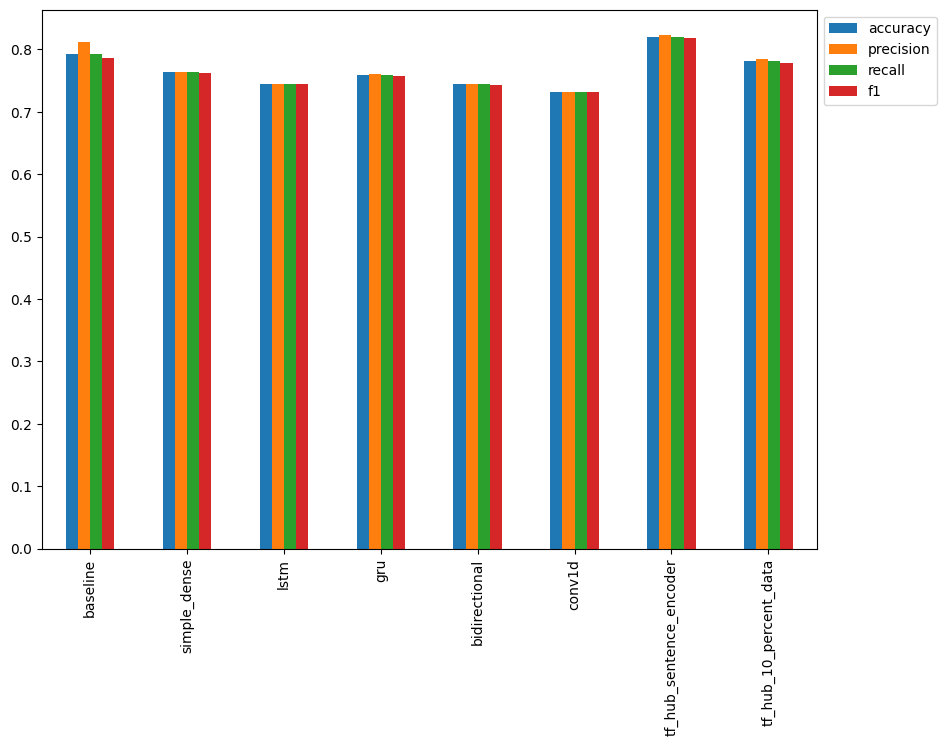

In [102]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

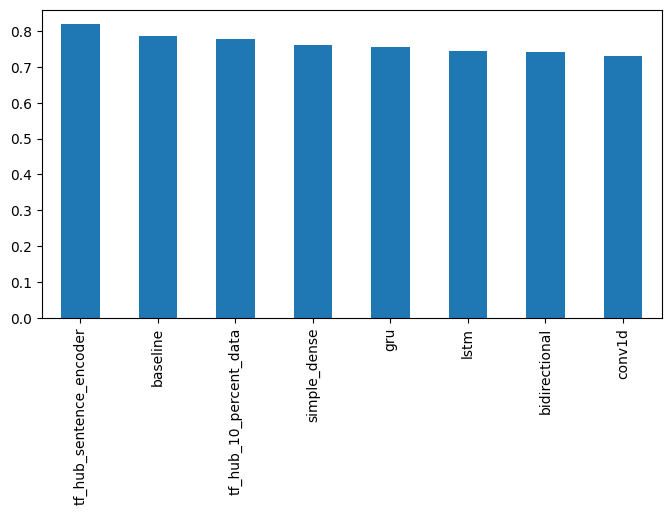

In [103]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(8, 4));

# Combining our models (model ensembling/stacking)

In [106]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_prob_preds, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1.], dtype=float32)>

In [107]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 75.06561679790026,
 'precision': 0.754934930008749,
 'recall': 0.7506561679790026,
 'f1': 0.7511206684112325}

In [108]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [109]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [110]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.763780,0.764216,0.763780,0.762258
lstm,0.744094,0.745138,0.744094,0.744400
gru,0.758530,0.759607,0.758530,0.756475
bidirectional,0.744094,0.744119,0.744094,0.742509
conv1d,0.732283,0.731770,0.732283,0.731164
tf_hub_sentence_encoder,0.820210,0.822322,0.820210,0.818824
tf_hub_10_percent_data,0.780840,0.784489,0.780840,0.778123
ensemble_results,0.750656,0.754935,0.750656,0.751121


# Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of saving a model in TensorFlow:

* The HDF5 format
* The SavedModel format (default)


In [111]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
# If you save a model as a HDF5, when loading it back in, you need to let
# TensorFlow know about any custom objects you've used (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [113]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4406 - accuracy: 0.8202


[0.4406431019306183, 0.8202099800109863]

In [114]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [115]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [116]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 14ms/step - loss: 0.4406 - accuracy: 0.8202


[0.4406430721282959, 0.8202099800109863]

# Finding the most wrong examples

In [117]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.115409
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.788165
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.999510
3,@camilacabello97 Internally and externally scr...,1,0.0,0.208318
4,Radiation emergency #preparedness starts with ...,1,1.0,0.653168


In [118]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
628,@noah_anyname That's where the concentration c...,0,1.0,0.978074
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.969236
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.951960
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.926785
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.924726
759,FedEx will no longer transport bioterror patho...,0,1.0,0.899509
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.880513
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.879895
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.879292
237,Came across this fire video not mine..enjoy..B...,0,1.0,0.863147


In [120]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9780738949775696
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.9692357182502747
Text:
Deaths 3 http://t.co/nApviyGKYK

----

Target: 0, Pred: 1, Prob: 0.9519602656364441
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.926784873008728
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9247264862060547
Text:
åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo

----

Target: 0, Pred: 1, Prob: 0.8995089530944824
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8805133700370789
Text:
Ashes 2015: AustraliaÛªs collapse at

In [121]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.040327008813619614
Text:
Rand Paul's Debate Strategy 'demolish Some other bad ideas out there or point out maybe that there are some em... http://t.co/qzdqRBr4Lh

----

Target: 1, Pred: 0, Prob: 0.03392476588487625
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

----

Target: 1, Pred: 0, Prob: 0.03380629047751427
Text:
Perspectives on the Grateful Dead: Critical Writings (Contributions to the Study http://t.co/fmu0fnuMxf http://t.co/AgGRyhVXKr

----

Target: 1, Pred: 0, Prob: 0.032380662858486176
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

----

Target: 1, Pred: 0, Prob: 0.031503088772296906
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.029777731746435165
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNE

# Predicting on Tweets from the wild

In [122]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [123]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [124]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 71ms/step
Pred: 0.0 (not real disaster) Prob: 0.07991961389780045
Text:
Life like an ensemble: take the best choices from others and make your own


In [125]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [126]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 52ms/step
Pred: 1.0 (real disaster) Prob: 0.9953025579452515
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [127]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 54ms/step
Pred: 1.0 (real disaster) Prob: 0.9971217513084412
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon
